## Plate_4042 Red Spectra Analysis

In [8]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import collections

In [9]:
from scipy import stats as scipy_stats

In [10]:
import bossdata
print(bossdata.__version__)

0.3.1


In [11]:
import bossdata.path
import bossdata.remote
import bossdata.meta 
import bossdata.spec as spec
import bossdata.plate as plate

In [12]:
import astropy.io.fits as fits
from astropy.table import Table
from astropy import stats as as_stats

In [13]:
import fitsio
from fitsio import FITS, FITSHDR

In [14]:
from operator import and_

In [15]:
import os
workdir = os.environ['SCRATCH']
os.environ["BOSS_DATA_URL"] = 'http://dr12.sdss3.org'
os.environ["BOSS_LOCAL_ROOT"] = os.path.join(workdir,'sdss')
os.environ["BOSS_SAS_PATH"] = '/sas/dr12/boss'
os.environ["BOSS_REDUX_VERSION"]='v5_7_0'

In [16]:
os.chdir(workdir)
os.getcwd()

'/scratch/kunjias'

In [17]:
finder = bossdata.path.Finder()
mirror = bossdata.remote.Manager()

#### Simulated fibers by spectrograph

Whole range of fibers from 1-500 and 501-1000. Analysis proceeds with fibers by object type.

In [18]:
all_fibers1 = np.arange(1,501,1)

In [19]:
all_fibers2 = np.arange(501,1001,1)

### PlateFile


The PlugMap which contains Object type information is accessed through the Plate File to obtain the sky fiber ID data, and the fiber ID for other object types.

In [20]:
plate_file_path = finder.get_plate_spec_path(plate=4042,mjd=55626)

In [21]:
plate_file_path

'/sas/dr12/boss/spectro/redux/v5_7_0/4042/spPlate-4042-55626.fits'

In [22]:
plate_file = mirror.get(plate_file_path, progress_min_size=2,auto_download=True, local_paths=None)

In [23]:
plate_file

'/scratch/kunjias/sdss/sas/dr12/boss/spectro/redux/v5_7_0/4042/spPlate-4042-55626.fits'

In [24]:
whole_plate = plate.PlateFile(plate_file)

In [25]:
type(plate)

module

In [26]:
type(whole_plate)

bossdata.plate.PlateFile

The number of science exposures used for this target’s co-added spectrum (counting a blue+red pair as one exposure).

In [27]:
whole_plate.num_exposures

5

In [28]:
plug_map = whole_plate.plug_map

In [29]:
type(plug_map)

astropy.table.table.Table

In [30]:
plug_map.columns

<TableColumns names=('OBJID','HOLETYPE','RA','DEC','MAG','STARL','EXPL','DEVAUCL','OBJTYPE','XFOCAL','YFOCAL','SPECTROGRAPHID','FIBERID','THROUGHPUT','PRIMTARGET','SECTARGET','OFFSETID','SCI_EXPTIME','SOURCETYPE','LAMBDA_EFF','ZOFFSET','BLUEFIBER','BOSS_TARGET1','BOSS_TARGET2','ANCILLARY_TARGET1','ANCILLARY_TARGET2','RUN','RERUN','CAMCOL','FIELD','ID','CALIBFLUX','CALIBFLUX_IVAR','CALIB_STATUS','SFD_EBV')>

In [31]:
#plug_map

In [32]:
plug_map_by_OBJTYPE = plug_map.group_by('OBJTYPE')

In [33]:
#print (plug_map_by_OBJTYPE)

In [34]:
print(plug_map_by_OBJTYPE.groups.keys)

    OBJTYPE     
----------------
GALAXY          
NA              
QSO             
SKY             
SPECTROPHOTO_STD


In [35]:
print(plug_map_by_OBJTYPE.groups.indices)

[   0  660  687  883  980 1000]


In [36]:
print(plug_map.group_by(['OBJTYPE','FIBERID']).groups.keys)

    OBJTYPE      FIBERID
---------------- -------
GALAXY                 1
GALAXY                 3
GALAXY                 5
GALAXY                 7
GALAXY                 9
GALAXY                11
GALAXY                13
GALAXY                17
GALAXY                19
GALAXY                21
             ...     ...
SPECTROPHOTO_STD     506
SPECTROPHOTO_STD     548
SPECTROPHOTO_STD     590
SPECTROPHOTO_STD     650
SPECTROPHOTO_STD     744
SPECTROPHOTO_STD     748
SPECTROPHOTO_STD     804
SPECTROPHOTO_STD     826
SPECTROPHOTO_STD     906
SPECTROPHOTO_STD     908
SPECTROPHOTO_STD     946
Length = 1000 rows


#### Sky fibers

In [37]:
sky = plug_map_by_OBJTYPE.groups[3]

In [38]:
#print(sky)

In [39]:
type(sky['FIBERID'])

astropy.table.column.Column

In [40]:
#sky['FIBERID']

In [41]:
sky_fibers = np.array(sky['FIBERID'])

In [42]:
sky_fibers

array([ 14,  15,  24,  30,  44,  48,  80,  88,  90, 102, 106, 112, 130,
       134, 142, 156, 168, 175, 188, 204, 216, 228, 252, 260, 276, 286,
       296, 310, 314, 322, 328, 352, 356, 372, 374, 394, 398, 402, 412,
       430, 436, 450, 452, 462, 490, 498, 499, 510, 514, 524, 536, 546,
       552, 566, 576, 592, 598, 610, 616, 627, 640, 641, 652, 664, 667,
       684, 686, 704, 708, 724, 728, 754, 756, 770, 780, 794, 796, 802,
       812, 824, 837, 844, 858, 866, 870, 884, 890, 914, 916, 932, 936,
       952, 954, 962, 980, 984, 986], dtype=int32)

In [43]:
len(sky_fibers)

97

There are 97 sky fiberrs among the 1000 fibers in plate_4042, which is around the average 10% sky fiber ratio in BOSS Survey design. The same set of sky fiber ID is taken to check on fiber type on other plates. Other plates may not contain sky fibers at the exact same fiber ID.

A function that return a numpy array of sky fiber IDs given a plate number.

In [44]:
def get_skyfiber(plate_number = 4042, mjd=55626):
    '''Return a numpy array of sky fiber IDs from a given plate
    
    Parameters
    -----------
    plate_number: Specified plate number. Default plate number is 4042.
    mjd: modified julian date of the observation associated with input plate. Default mjd is 55626.
    
    Output
    -------
    An array of sky fiber IDs.
    '''
    
    plate_file_path = finder.get_plate_spec_path(plate_number, mjd)
    plate_file = mirror.get(plate_file_path, progress_min_size=2, auto_download=True, local_paths=None)
    whole_plate = plate.PlateFile(plate_file)
    plug_map = whole_plate.plug_map
    plug_map_by_OBJTYPE = plug_map.group_by('OBJTYPE')
    
    #print(plug_map_by_OBJTYPE.groups.keys)
    #print(plug_map_by_OBJTYPE.groups.indices)
    #print(plug_map.group_by(['OBJTYPE','FIBERID']).groups.keys)
    
    sky = plug_map_by_OBJTYPE.groups[3]
    sky_fibers = np.array(sky['FIBERID'])
    fiber_number = len(sky_fibers)
    
    print("Plate", plate_number, "contains", fiber_number, "sky_fibers with fiber IDs at", sky_fibers)

In [45]:
get_skyfiber(4042, 55626)

Plate 4042 contains 97 sky_fibers with fiber IDs at [ 14  15  24  30  44  48  80  88  90 102 106 112 130 134 142 156 168 175
 188 204 216 228 252 260 276 286 296 310 314 322 328 352 356 372 374 394
 398 402 412 430 436 450 452 462 490 498 499 510 514 524 536 546 552 566
 576 592 598 610 616 627 640 641 652 664 667 684 686 704 708 724 728 754
 756 770 780 794 796 802 812 824 837 844 858 866 870 884 890 914 916 932
 936 952 954 962 980 984 986]


In [46]:
get_skyfiber(3586, 55181)

Plate 3586 contains 20 sky_fibers with fiber IDs at [  4 132 156 220 234 242 278 384 408 416 470 524 563 568 682 768 814 866
 892 898]


In [47]:
# get_skyfiber(4004,55321)
# get_skyfiber(5000,55715)
# get_skyfiber(6000, 56102)
# get_skyfiber(7027, 56448)

#### Sky Fibers seperated by Spectrograph in Plate 4042

In [48]:
def spec1_fiber(fibers):
    fibers1 = []
    for i in range(0,len(fibers)):
        if fibers[i] < 501:
            fibers1.append(fibers[i])
    return fibers1

In [49]:
def spec2_fiber(fibers):
    fibers2 = []
    for i in range(0,len(fibers)):
        if fibers[i] >= 501:
            fibers2.append(fibers[i])
    return fibers2

In [50]:
sky_fibers1 = spec1_fiber(sky_fibers)

In [51]:
#sky_fibers1

In [52]:
len(sky_fibers1)

47

In [53]:
sky_fibers2 = spec2_fiber(sky_fibers)

In [54]:
#sky_fibers2

In [55]:
len(sky_fibers2)

50

#### Non-SKY Fibers

In [56]:
non_sky_fibers1 = list(filter(lambda x: x not in sky_fibers1, all_fibers1))

In [57]:
len(non_sky_fibers1)

453

In [58]:
non_sky_fibers2 = list(filter(lambda x: x not in sky_fibers2, all_fibers2))

In [59]:
len(non_sky_fibers2)

450

## Plate 4042 plan file

Path to plan file and download to workspace.

In [60]:
combined_plan_path = finder.get_plate_plan_path(plate=4042,mjd=55626, combined=True)

In [61]:
combined_plan_path

'/sas/dr12/boss/spectro/redux/v5_7_0/4042/spPlancomb-4042-55626.par'

In [62]:
combined_plan_file = mirror.get(combined_plan_path, progress_min_size=2,auto_download=True, local_paths=None)

In [63]:
combined_plan_file

'/scratch/kunjias/sdss/sas/dr12/boss/spectro/redux/v5_7_0/4042/spPlancomb-4042-55626.par'

The plan file for configuring BOSS pipeline to combined exposures of plate 4042.

In [64]:
combined_plan = plate.Plan(combined_plan_file)

In [65]:
combined_plan.num_science_exposures

7

Get the spectrograph index.

In [66]:
combined_plan.get_spectrograph_index(1)

1

In [67]:
combined_plan.get_spectrograph_index(500)

1

In [68]:
combined_plan.get_spectrograph_index(501)

2

In [69]:
combined_plan.get_spectrograph_index(1000)

2

### Exposure[0], Spectrograph 1, Fiber 1-500

Locate and download the file of a single science exposure for spectrogtaph 1. The exposure file to return is set to 'spCFrame'.

In [70]:
exp0_spec1_path = combined_plan.get_exposure_name(sequence_number=0,band='red',fiber=1,ftype='spCFrame')

In [71]:
combined_plan.get_exposure_name(sequence_number=6,band='red',fiber=1,ftype='spCFrame')

'/sas/dr12/boss/spectro/redux/v5_7_0/4042/spCFrame-r1-00127692.fits'

In [72]:
exp0_spec1_path

'/sas/dr12/boss/spectro/redux/v5_7_0/4042/spCFrame-r1-00127588.fits'

In [73]:
exp0_spec1_file = mirror.get(exp0_spec1_path)

In [74]:
exp0_spec1_file

'/scratch/kunjias/sdss/sas/dr12/boss/spectro/redux/v5_7_0/4042/spCFrame-r1-00127588.fits'

#### Frame file of exposure[0] of spectrograph 1

Frame file containing single exposure 0 of spectrograph 1 (half plate).

In [75]:
expo0_spec1_frame = plate.FrameFile(exp0_spec1_file, index=1, calibrated = True)

In [76]:
# expo0_spec1_frame
print('plate_number:',expo0_spec1_frame.plate,
'camera:',expo0_spec1_frame.camera,
'exposure_id:',expo0_spec1_frame.exposure_id)
# expo0_spec1_frame.header

plate_number: 4042 camera: r1 exposure_id: 127588


In [77]:
expo0_spec1_frame.exposure_id

127588

#### Concern with wavelength shifts?

In [78]:
fiber2 = expo0_spec1_frame.get_valid_data(fibers = [2],pixel_quality_mask=None, include_wdisp=False, include_sky=True, use_ivar=True, use_loglam=False)

In [79]:
fiber3 = expo0_spec1_frame.get_valid_data(fibers = [3],pixel_quality_mask=None, include_wdisp=False, include_sky=True, use_ivar=True, use_loglam=False)

In [80]:
fiber2.shape

(1, 4128)

In [81]:
fiber3.shape

(1, 4128)

In [82]:
wavelength_2 = fiber2['wavelength'].data

In [83]:
wavelength_3 = fiber3['wavelength'].data

In [84]:
np.mean((wavelength_3 - wavelength_2)/wavelength_2)

-3.5473622e-05

In [85]:
np.mean((wavelength_3 - wavelength_2)/wavelength_3)

-3.547517e-05

The BOSS spectroscopic data is taken under resolution of 1500 at 3800 Å, 2500 at 9000 Å.

In [86]:
1/2500

0.0004

In [87]:
1/1500

0.0006666666666666666

The percentage change in wavelength data between fiber2 and fiber 3 is less than 1%, and inverse of BOSS's resolution is larger than the percentage change in wavelength difference between fibers. Thus, the wavelength shift is negligible. (These two fibers are taken as examples.)

In [88]:
sky_fibers1[0]

14

#### Get valid data for the 47 sky fibers in Spectrograph 1.

In [89]:
spec1_sky = expo0_spec1_frame.get_valid_data(fibers = sky_fibers1,pixel_quality_mask=None, include_wdisp=False, include_sky=True, use_ivar=True, use_loglam=False)

In [90]:
#spec1_sky

In [91]:
spec1_sky.shape

(47, 4128)

In [92]:
type(spec1_sky)

numpy.ma.core.MaskedArray

Access the wavelength, flux, sky, and ivar fields by creating new masked arrays.

#### Wavelength

In [93]:
wavelength_spec1 = spec1_sky['wavelength']

In [94]:
wavelength_spec1.shape

(47, 4128)

Total number of data points if all are valid.

In [95]:
47 * 4128

194016

Count the number of non-masked elements along rows (fibers).

In [96]:
wavelength_spec1.count(axis=1)

array([4128, 4128, 4128, 4128, 4128, 4128, 4128, 4128, 4128, 4128, 4128,
       4128, 4128, 4128, 4128, 4128, 4128, 4128, 4128, 4128, 4128, 4128,
       4128, 4128, 4128, 4128, 4128, 4128, 4128, 4128, 4128, 4128, 4128,
       4128, 4128, 4128, 4128, 4128, 4128, 4128, 4128, 4128, 4128, 4128,
       4128, 4128, 4128])

Total number of valid elements in the wavelength  masked array.

In [97]:
wavelength_spec1.count(axis=1).sum()

194016

In [98]:
47 * 4128

194016

#### Compare wavelength shift in the same fiber across exposures

A function that returns an array of wavelength from given plate and exposure with specified fiber and spectrograph input.

In [99]:
def get_wavelength(plate_number=4042, mjd=55626, exposure=0, fiber_number= sky_fibers1[0], index=1, fibers=sky_fibers1,combined = True):
    '''Compute masked array of wavelength from a given plate at specific mjd and exposure time.
    
    Parameters
    -----------
    plate_number: Specified plate number. Default plate number is 4042.
    
    mjd: modified julian date of the observation associated with input plate. Default mjd is 55626.
    
    exposure: Science exposure sequence number specifying requested exposure.
    
    fiber_number: fiber number to identify which spectrograph to retreive the exposure data,
    1-500 for spectrograph 1, and 501-1000 for spectrograph 2.
    
    index: identification for spectrograph.1 for first spectrograph, and 2 for second spectrograph.
    
    fibers: a list of fiber IDs to obtain the spectra from
    
    Output
    -------
    A numpy array of wavelength data of the input plate at specified exposure.
    '''
    combined_plan_path = finder.get_plate_plan_path(plate_number,mjd, combined=True)
    combined_plan_file = mirror.get(combined_plan_path, progress_min_size=2,auto_download=True, local_paths=None)
    combined_plan = plate.Plan(combined_plan_file)
    exp_spec_path = combined_plan.get_exposure_name(sequence_number=exposure,band='red',fiber=fiber_number,ftype='spCFrame')
    exp_spec_file = mirror.get(exp_spec_path)
    exp_spec_frame = plate.FrameFile(exp_spec_file, index, calibrated = True)
    valid_spec = exp_spec_frame.get_valid_data(fibers,pixel_quality_mask=None, include_wdisp=False, include_sky=True, use_ivar=True, use_loglam=False)
    wavelength_spec = valid_spec['wavelength'].data
    
    return wavelength_spec

In [100]:
#get_wavelength(plate_number=4042, mjd=55626, exposure=0, fiber_number= sky_fibers1[0], index=1, fibers=sky_fibers1,combined = True)

In [101]:
(get_wavelength()== wavelength_spec1).all()

True

Two missng SpCFrame fits files from /sas/dr12/boss/spectro/redux/v5_7_0/4042 index.

In [102]:
combined_plan.get_exposure_name(sequence_number=2,band='red',fiber=1,ftype='spCFrame')

'/sas/dr12/boss/spectro/redux/v5_7_0/4042/spCFrame-r1-00127592.fits'

In [103]:
combined_plan.get_exposure_name(sequence_number=3,band='red',fiber=1,ftype='spCFrame')

'/sas/dr12/boss/spectro/redux/v5_7_0/4042/spCFrame-r1-00127593.fits'

Check for wavelength change for the same set of sky fibers. (47 sky fibers from spectrograph 1 in plate 4042).

In [104]:
expo0_wavelength = get_wavelength()

In [105]:
expo0_wavelength.shape

(47, 4128)

In [106]:
expo1_wavelength = get_wavelength(exposure=1)

In [107]:
expo1_wavelength[0].shape

(4128,)

In [108]:
expo4_wavelength = get_wavelength(exposure=4)

In [109]:
expo5_wavelength = get_wavelength(exposure=5)

In [110]:
expo6_wavelength = get_wavelength(exposure=6)

In [111]:
F, p = scipy_stats.f_oneway(expo0_wavelength[0],expo1_wavelength[0])

In [112]:
F

3.852228229721464e-06

In [113]:
p

0.9984340329394463

In [114]:
residual_e0_1_f0 = expo1_wavelength[0] - expo0_wavelength[0]

In [115]:
print('Minimum',np.min(residual_e0_1_f0))
print('Median',np.median(residual_e0_1_f0))
print('Maximum',np.max(residual_e0_1_f0))
print('Mean', np.mean(residual_e0_1_f0))

Minimum -0.075683594
Median -0.07421875
Maximum -0.068359375
Mean -0.07353802


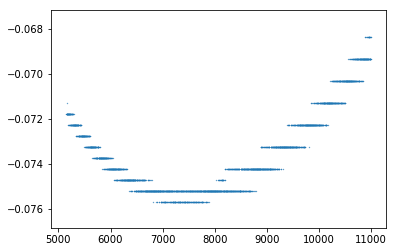

In [116]:
x = expo0_wavelength[0]
y = residual_e0_1_f0
plt.scatter(x,y, s=0.1)
plt.show()

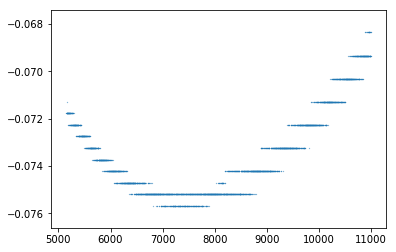

In [117]:
x = expo1_wavelength[0]
y = residual_e0_1_f0
plt.scatter(x,y,s=0.05)
plt.show()

In [118]:
residual_e0_1_f20 = expo1_wavelength[20] - expo0_wavelength[20]

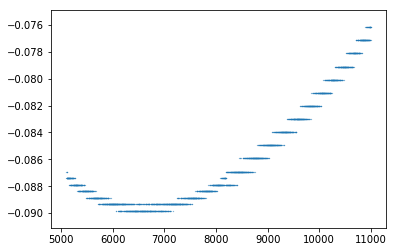

In [119]:
x = expo0_wavelength[20]
y = residual_e0_1_f20
plt.scatter(x,y,s=0.05)
plt.show()

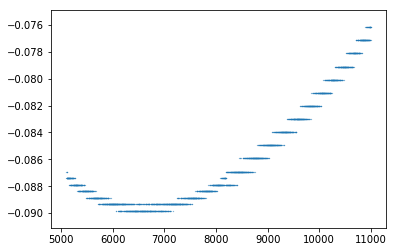

In [120]:
x = expo1_wavelength[20]
y = residual_e0_1_f20
plt.scatter(x,y,s=0.05)
plt.show()

In [121]:
residual_e0_1_f40 = expo1_wavelength[40] - expo0_wavelength[40]

In [122]:
print('Minimum',np.min(residual_e0_1_f40))
print('Median',np.median(residual_e0_1_f40))
print('Maximum',np.max(residual_e0_1_f40))
print('Mean', np.mean(residual_e0_1_f40))

Minimum -0.06347656
Median -0.040527344
Maximum -0.009765625
Mean -0.039239336


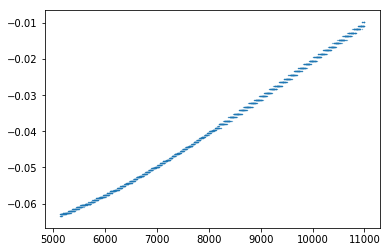

In [123]:
x = expo0_wavelength[40]
y = residual_e0_1_f40
plt.scatter(x,y,s=0.05)
plt.show()

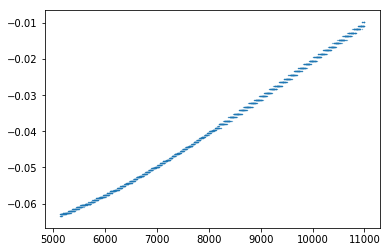

In [124]:
x = expo1_wavelength[40]
y = residual_e0_1_f40
plt.scatter(x,y,s=0.05)
plt.show()

#### Flux

In [125]:
flux_spec1 = spec1_sky['flux']

In [126]:
flux_spec1.shape

(47, 4128)

Count the number of non-masked elements along rows (fibers).

In [127]:
flux_spec1.count(axis=1)

array([2224, 2243, 2203, 2159, 2220, 2248, 2186, 2195, 2172, 2184, 2160,
       2211, 2160, 2189, 2190, 2187, 2189, 2213, 2195, 2201, 2159, 2181,
       2199, 2177, 2182, 2152, 2161, 2180, 2183, 2150, 2207, 2169, 2175,
       2181, 2180, 2129, 2170, 2162, 2175, 2182, 2178, 2175, 2200, 2182,
       2237, 2189, 2212])

Total number of valid elements in the flux  masked array.

In [128]:
flux_spec1.count(axis=1).sum()

102756

In [129]:
47 * 4128

194016

#### Sky

In [130]:
sky_spec1 = spec1_sky['sky']

In [131]:
type(sky_spec1)

numpy.ma.core.MaskedArray

Count the number of non-masked elements along rows (fibers).

In [132]:
sky_spec1.count(axis=1)

array([2224, 2243, 2203, 2159, 2220, 2248, 2186, 2195, 2172, 2184, 2160,
       2211, 2160, 2189, 2190, 2187, 2189, 2213, 2195, 2201, 2159, 2181,
       2199, 2177, 2182, 2152, 2161, 2180, 2183, 2150, 2207, 2169, 2175,
       2181, 2180, 2129, 2170, 2162, 2175, 2182, 2178, 2175, 2200, 2182,
       2237, 2189, 2212])

Total number of valid elements in the sky  masked array.

In [133]:
sky_spec1.count(axis=1).sum()

102756

#### Sky + Flux

In [134]:
total_flux_spec1 = np.ma.array(flux_spec1.data+sky_spec1.data, mask=list(map(and_,flux_spec1.mask, sky_spec1.mask)))

In [135]:
total_flux_spec1.shape

(47, 4128)

Count the number of non-masked elements along rows (fibers).

In [136]:
total_flux_spec1.count(axis=1)

array([2224, 2243, 2203, 2159, 2220, 2248, 2186, 2195, 2172, 2184, 2160,
       2211, 2160, 2189, 2190, 2187, 2189, 2213, 2195, 2201, 2159, 2181,
       2199, 2177, 2182, 2152, 2161, 2180, 2183, 2150, 2207, 2169, 2175,
       2181, 2180, 2129, 2170, 2162, 2175, 2182, 2178, 2175, 2200, 2182,
       2237, 2189, 2212])

Check the total number of valid data in total_flux.

In [137]:
len(total_flux_spec1.compressed())

102756

#### Inverse Variance

Inverse Variance is used as weights to computed the weighted average of total flux for sky fibers.

In [138]:
ivar_spec1 = spec1_sky['ivar']

In [139]:
type(ivar_spec1)

numpy.ma.core.MaskedArray

In [140]:
ivar_spec1.shape

(47, 4128)

Check number of valid data in the inverse variance masked array.

In [141]:
ivar_spec1.count(axis=1).sum()

102756

Fill in the invalid inverse variance data with value 0.

In [142]:
weights_by_ivar = ma.filled(ivar_spec1, fill_value=0)

In [143]:
type(weights_by_ivar)

numpy.ndarray

In [144]:
weights_by_ivar.shape

(47, 4128)

A plot for the total flux among the 47 sky fibers in spectrograph 1.

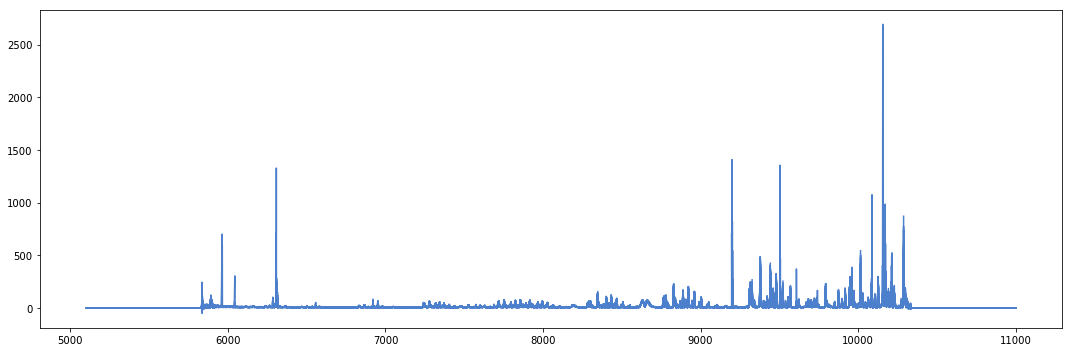

In [145]:
x = wavelength_spec1.data
y = total_flux_spec1.data

plt.figure(figsize = (15,5))
plt.plot(x,y,c =[0.3,0.5,0.8])
plt.tight_layout()
plt.show()

##### Simple Average
Average of total_flux among 47 sky fibers with no weights.

In [146]:
simple_average = ma.average(total_flux_spec1, axis=0, returned=False)

In [147]:
type(simple_average)

numpy.ma.core.MaskedArray

In [148]:
simple_average_flux1 = simple_average.data

Wavelength from the first sky fiber (fiber no.14) is taken as the standard wavelength scale to plot the total_flux here.

In [149]:
wavelength_fiber14 = wavelength_spec1[0]

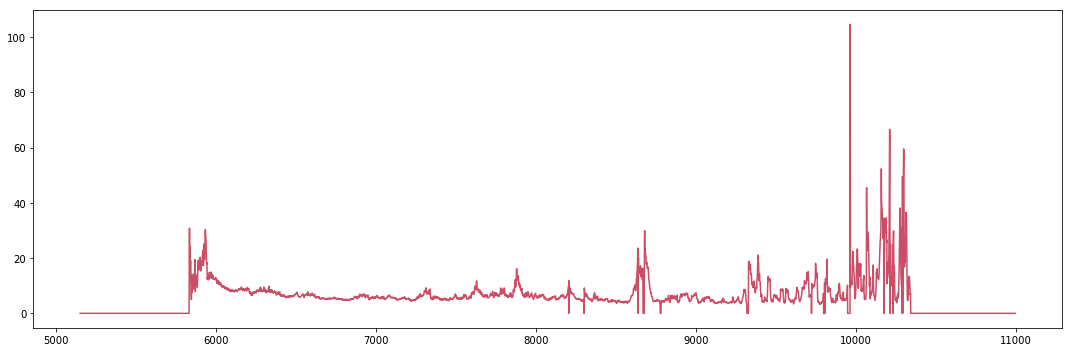

In [150]:
x = wavelength_fiber14
y = simple_average_flux1

plt.figure(figsize = (15,5))
plt.plot(x,y,c =[0.8,0.3,0.4])
plt.tight_layout()
plt.show()

#### Weighted Average
Average of total_flux of 47 sky fibers in spectrograph 1 weighted by inverse variance.

In [151]:
weighted_average_spec1 = ma.average(total_flux_spec1,axis=0, weights = weights_by_ivar, returned= False)

In [152]:
type(weighted_average_spec1)

numpy.ma.core.MaskedArray

In [153]:
average_sky_flux1 = weighted_average_spec1.data

Wavelegnth from the first sky fiber (fiber no.14) is taken as the standard wavelength scale to plot the total_flux here.

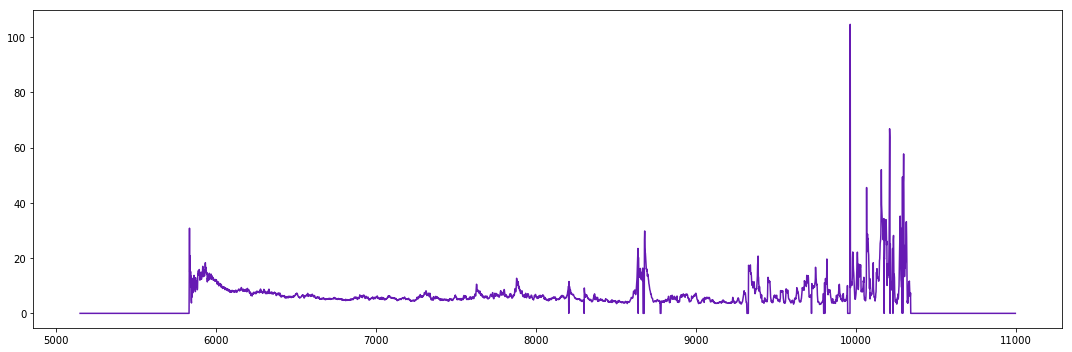

In [154]:
x = wavelength_fiber14
y = average_sky_flux1

plt.figure(figsize = (15,5))
plt.plot(x,y,c =[0.4,0.1,0.7])
plt.tight_layout()
plt.show()

Calculate the residuals when subtracted from total_flux_spec1, total flux of the sky fibers.

#### Residuals
Total Flux of Sky Fibers - Average Sky Signal (weighted average)

Replicate average_sky_flux1 to dimension of (47, 4128).

In [155]:
repeated47_average_sky_flux1 = np.tile(average_sky_flux1,(47,1))

In [156]:
repeated47_average_sky_flux1.shape

(47, 4128)

In [157]:
average_sky_residuals = np.ma.array(total_flux_spec1.data - repeated47_average_sky_flux1, mask = total_flux_spec1.mask)

In [158]:
average_sky_residuals.shape

(47, 4128)

In [159]:
np.min(average_sky_residuals.data)

-64.74988

In [160]:
np.median(average_sky_residuals.data)

0.0

In [161]:
np.max(average_sky_residuals.data)

2655.9468

In [162]:
np.std(average_sky_residuals.data)

33.204456

In [163]:
scipy_stats.iqr(average_sky_residuals.data)

3.059052348136902

A plot of wavelength vs. residuals of total flux subtracted by average flux from 47 sky fibers.

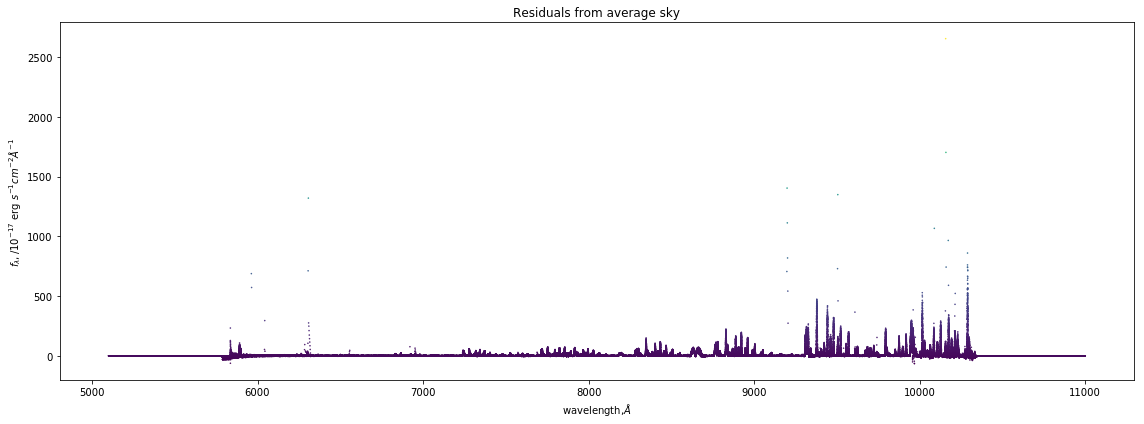

In [164]:
x = wavelength_spec1.data
y = average_sky_residuals.data

plt.figure(figsize = (16,6))
plt.scatter(x,y,s=0.3,c=y)
plt.title("Residuals from average sky")
plt.xlabel("wavelength,$\AA$")
plt.ylabel("$f_{\lambda}, / 10^{-17}$ erg $s^{-1} cm^{-2} \AA^{-1}$")
plt.tight_layout()
plt.show()

#### Scaling of total flux by weighted average and noise variance

Total flux from 47 sky fibers are scaled by subtracting weighted average then divided by the noise standard deviation sigma.

In [165]:
scaled_total_sky = np.ma.array((total_flux_spec1.data - repeated47_average_sky_flux1) * ((ivar_spec1.data)**0.5),mask = list(map(and_, total_flux_spec1.mask,ivar_spec1.mask))) 

In [166]:
scaled_total_sky.shape

(47, 4128)

In [167]:
type(scaled_total_sky)

numpy.ma.core.MaskedArray

In [168]:
wavelength_spec1.shape

(47, 4128)

In [169]:
scaled_total_sky.count()

102756

In [170]:
scaled_sky_signal = ma.filled(scaled_total_sky, fill_value=0)

In [171]:
type(scaled_sky_signal)

numpy.ndarray

In [172]:
scaled_sky_signal.shape

(47, 4128)

In [173]:
wavelength_spec1.shape

(47, 4128)

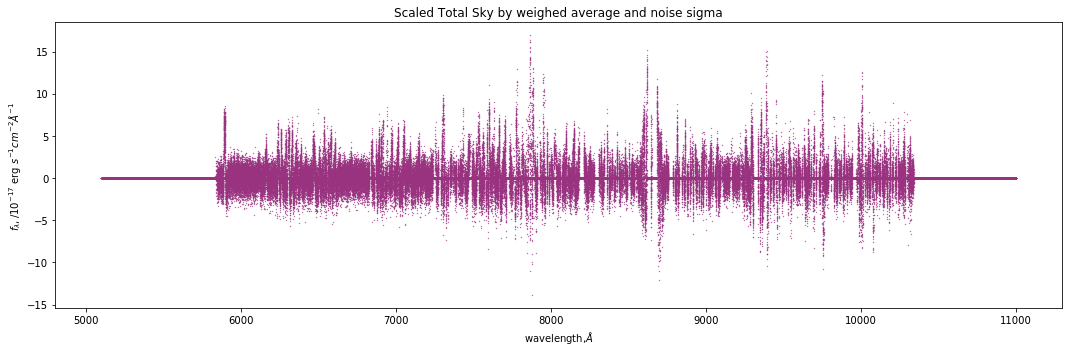

In [174]:
x = wavelength_spec1.data
y = scaled_total_sky.data

plt.figure(figsize = (15,5))
plt.title("Scaled Total Sky by weighed average and noise sigma")
plt.xlabel("wavelength,$\AA$")
plt.ylabel("$f_{\lambda}, / 10^{-17}$ erg $s^{-1} cm^{-2} \AA^{-1}$")

plt.scatter(x,y,s=0.1, c=[0.6,0.2,0.5])
plt.tight_layout()
plt.show()

### Heat Map of scaled sky fiber total flux

In [175]:
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import matplotlib as mpl

import pandas as pd
%matplotlib inline

In [176]:
scaled_total_sky[0:3,:].shape

(3, 4128)

In [177]:
a = scaled_total_sky[0,:]

In [178]:
b = scaled_total_sky[1,:]

In [179]:
c = scaled_total_sky[2:]

In [180]:
np.max(a)

13.710624

In [181]:
np.min(a)

-11.068112

In [182]:
np.max(b)

14.177226

In [183]:
np.min(b)

-10.45649

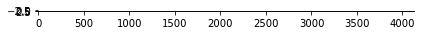

In [184]:
fig,ax = plt.subplots()
ax.imshow(scaled_total_sky[0:3,:], cmap='hot')
fig.tight_layout()
plt.show()

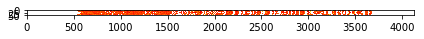

In [185]:
fig,ax = plt.subplots()
ax.imshow(scaled_total_sky, cmap='hot')
fig.tight_layout()
plt.show()

#### IQR
interquartile range of scaled total flux data across fiber.

In [186]:
scaled_total_iqr = scipy_stats.iqr(scaled_total_sky.data, axis =0)

In [187]:
scaled_total_25p = np.percentile(scaled_total_sky.data, 25, axis=0)

In [188]:
scaled_total_75p = np.percentile(scaled_total_sky.data, 75, axis=0)

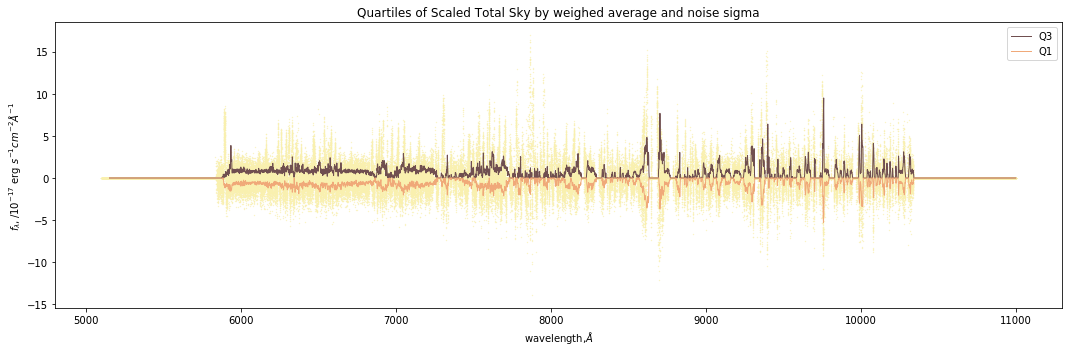

In [189]:
x = wavelength_fiber14
y75 = scaled_total_75p
y25 = scaled_total_25p

x2 = wavelength_spec1.data
y2 = scaled_total_sky.data

plt.figure(figsize = (15,5))
plt.title("Quartiles of Scaled Total Sky by weighed average and noise sigma")
plt.xlabel("wavelength,$\AA$")
plt.ylabel("$f_{\lambda}, / 10^{-17}$ erg $s^{-1} cm^{-2} \AA^{-1}$")

plt.plot(x,y75,linewidth=1, label ='Q3',c='#704F50')
plt.plot(x,y25,linewidth=1, label='Q1', c='#F0A979')
plt.scatter(x2,y2,s=0.1, c='#F9F0AF')
plt.legend()
plt.tight_layout()
plt.show()

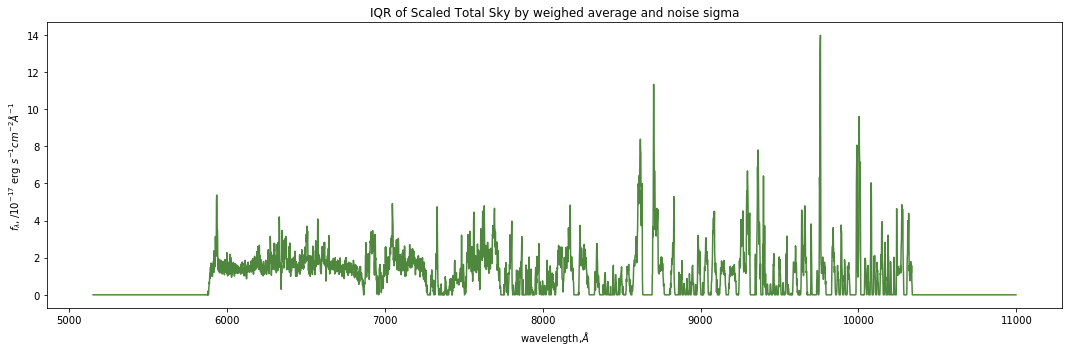

In [190]:
x = wavelength_fiber14
y = scaled_total_iqr

plt.figure(figsize = (15,5))
plt.title("IQR of Scaled Total Sky by weighed average and noise sigma")
plt.xlabel("wavelength,$\AA$")
plt.ylabel("$f_{\lambda}, / 10^{-17}$ erg $s^{-1} cm^{-2} \AA^{-1}$")

plt.plot(x,y,c='#4E873D')
plt.tight_layout()
plt.show()

### PCA on total flux from sky fibers
Data preperation and standardization process by sklearn.preprocessing.StandardScaler(). Data are standardized to have mean of 0 and standard deviation of 1 along columns (wavelength marks).

In [191]:
from sklearn import preprocessing

In [192]:
S = scaled_total_sky

In [193]:
type(S)

numpy.ma.core.MaskedArray

In [194]:
S.shape

(47, 4128)

In [195]:
S.mean(axis=0).count()

3110

In [196]:
S.std(axis=0).count()

3110

There are 3110 valid data columns.

In [197]:
scaler_S = preprocessing.StandardScaler().fit(S)

In [198]:
scaler_S.mean_

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [199]:
scaler_S.scale_

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [200]:
scaler_S.transform(S)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [201]:
scaler_S.transform(S).mean(axis=0)

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [202]:
scaler_S.transform(S).mean(axis=0).sum()

1.9356069e-06

In [203]:
(scaler_S.transform(S).std(axis=0)).shape

(4128,)

In [204]:
counter = collections.Counter(scaler_S.transform(S).std(axis=0))
print(counter)

Counter({1.0: 1201, 0.0: 1026, 0.9999999: 479, 0.99999994: 439, 1.0000001: 408, 0.9999998: 143, 1.0000002: 120, 0.99999976: 116, 1.0000004: 39, 0.99999964: 38, 0.9999997: 30, 1.0000005: 17, 0.9999996: 15, 0.9999995: 13, 1.0000006: 9, 0.99999946: 8, 1.0000007: 7, 0.99999934: 3, 0.9999993: 3, 0.9999992: 3, 1.000001: 3, 0.9999994: 3, 0.99999905: 1, 1.0000012: 1, 0.9999991: 1, 1.0000008: 1, 0.99999917: 1})


In [205]:
scaler_S.transform(S).std(axis=0).sum()

3102.0

In [206]:
np.sum(scaler_S.transform(S).mean(axis=0))

1.9356069e-06

In [207]:
np.sum(scaler_S.transform(S).std(axis=0))

3102.0

#### Fit the model and apply dimensionality reduction on total flux of 47 sky fibers
Perform the principal component analysis using sklearn.decomposition.

In [208]:
from sklearn import decomposition

In [209]:
total_flux_scaled_S = scaler_S.transform(S)

In [210]:
pca_S = decomposition.PCA(n_components =47)

In [211]:
pca_S.fit(total_flux_scaled_S)

PCA(copy=True, iterated_power='auto', n_components=47, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [212]:
print(pca_S.explained_variance_ratio_)

[1.06334947e-01 8.45579952e-02 6.75617009e-02 6.06866106e-02
 5.34903966e-02 4.13545370e-02 3.50465998e-02 3.14178243e-02
 3.03328466e-02 2.81149484e-02 2.43375264e-02 2.22204886e-02
 1.97249744e-02 1.94471870e-02 1.87522620e-02 1.83117781e-02
 1.63991023e-02 1.50570786e-02 1.50160482e-02 1.43437674e-02
 1.35702752e-02 1.32277664e-02 1.32243922e-02 1.26767587e-02
 1.23737510e-02 1.20488014e-02 1.19343065e-02 1.16920285e-02
 1.14278784e-02 1.13387397e-02 1.10697038e-02 1.08324001e-02
 1.06599890e-02 1.04849450e-02 1.03113241e-02 1.01121105e-02
 9.85481683e-03 9.57945734e-03 9.43667814e-03 9.33113694e-03
 9.20789037e-03 9.06226598e-03 8.94639548e-03 8.53759889e-03
 8.40792526e-03 8.14205315e-03 1.25733624e-15]


In [213]:
total_flux_scaled_S_reduced = pca_S.fit_transform(total_flux_scaled_S)

In [214]:
total_flux_scaled_S_reduced.shape

(47, 47)

Obtain the eigenvectors (directions of principal components) from attribute of PCA Class.

In [215]:
eigenvectors_S = pca_S.components_

In [216]:
eigenvectors_S.shape

(47, 4128)

Plot the first five eigenvectors from pca.

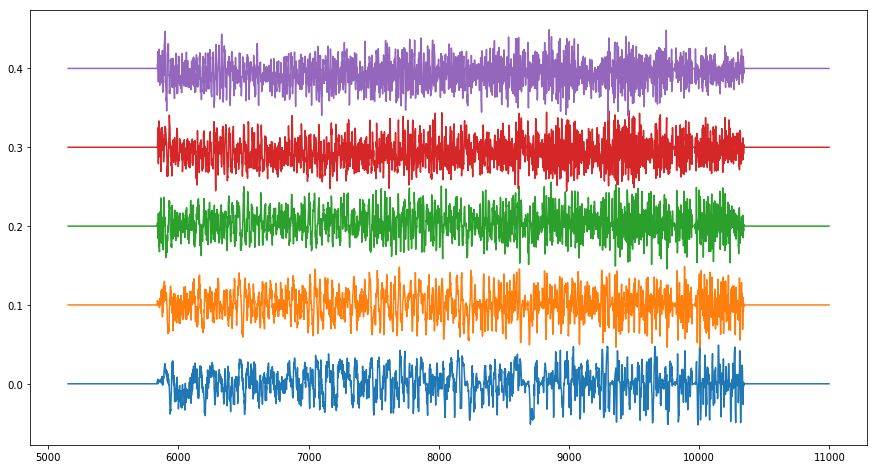

In [217]:
x = wavelength_spec1[0,:].data
y1 = eigenvectors_S[0]
y2 = eigenvectors_S[1]
y3 = eigenvectors_S[2]
y4 = eigenvectors_S[3]
y5 = eigenvectors_S[4]

plt.figure(figsize = (15,8))
plt.plot(x,y1,x,y2+0.1,x,y3+0.2,x,y4+0.3,x,y5+0.4)
plt.show()

Calculate the eigenvalues (principal component amplitudes) for 47 sky spectra.
$$
a_j = f \cdot e_j
$$

$a_j$ are the principal component amplitudes(eigenvalues), $e_j$ are the eigenvectors.

Eigenvalues for noise-weighted input spectrum.

In [218]:
eigenvalues_S = np.dot(scaled_total_sky.data, eigenvectors_S.T)

In [219]:
eigenvalues_S.shape

(47, 47)

In [220]:
type(eigenvalues_S)

numpy.ndarray

Reconstruct the input spectrum from eigenvectors and eigenvalues.
$$
f_k = \sum_{j=1}^{M} a_j e_{jk}
$$

In [221]:
projection_S = eigenvalues_S @ eigenvectors_S

In [222]:
type(projection_S)

numpy.ndarray

In [223]:
projection_S.shape

(47, 4128)

In [224]:
(ivar_spec1.data).shape

(47, 4128)

In [225]:
type(repeated47_average_sky_flux1)

numpy.ndarray

In [226]:
repeated47_average_sky_flux1.shape

(47, 4128)

Reverse the standardization process to get the original data from PCA projected total sky flux.

In [227]:
#np.seterr(divide='ignore', invalid='ignore')
projection_O = np.ma.array(projection_S / ((ivar_spec1.data)** 0.5) + repeated47_average_sky_flux1, mask= ivar_spec1.mask)

/project/6016730/mlhaa/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/project/6016730/mlhaa/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [228]:
projection_O.shape

(47, 4128)

In [229]:
type(projection_O)

numpy.ma.core.MaskedArray

In [230]:
projection_O_residual = np.ma.array(total_flux_spec1.data - projection_O.data, mask=list(map(and_,total_flux_spec1.mask, projection_O.mask)))

In [231]:
type(projection_O_residual)

numpy.ma.core.MaskedArray

In [232]:
projection_O_residual.shape

(47, 4128)

In [233]:
projection_O_residual.count()

102756

In [234]:
projection_O_residual.mean(axis=0).count()

3110

In [235]:
np.max(projection_O_residual.mean(axis=0))

7.906008633700284

In [236]:
np.median(projection_O_residual.mean(axis=0))

/project/6016730/mlhaa/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


0.0

In [237]:
np.mean(projection_O_residual.mean(axis=0))

0.09949841521402923

In [238]:
np.min(projection_O_residual.mean(axis=0))

-26.454867045084637

In [239]:
np.max(projection_O_residual.std(axis=0))

53.302646805034406

In [240]:
np.median(projection_O_residual.std(axis=0))

/project/6016730/mlhaa/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


0.3647171415603937

In [241]:
np.mean(projection_O_residual.std(axis=0))

1.2124088964031792

In [242]:
np.min(projection_O_residual.std(axis=0))

0.0

In [243]:
np.min(wavelength_spec1.data[0])

5153.2393

In [244]:
np.max(wavelength_spec1.data[46])

11000.265

In [245]:
np.arange(5150, 11001, step=100)

array([ 5150,  5250,  5350,  5450,  5550,  5650,  5750,  5850,  5950,
        6050,  6150,  6250,  6350,  6450,  6550,  6650,  6750,  6850,
        6950,  7050,  7150,  7250,  7350,  7450,  7550,  7650,  7750,
        7850,  7950,  8050,  8150,  8250,  8350,  8450,  8550,  8650,
        8750,  8850,  8950,  9050,  9150,  9250,  9350,  9450,  9550,
        9650,  9750,  9850,  9950, 10050, 10150, 10250, 10350, 10450,
       10550, 10650, 10750, 10850, 10950])

In [246]:
projection_O_residual.max()

46.226532

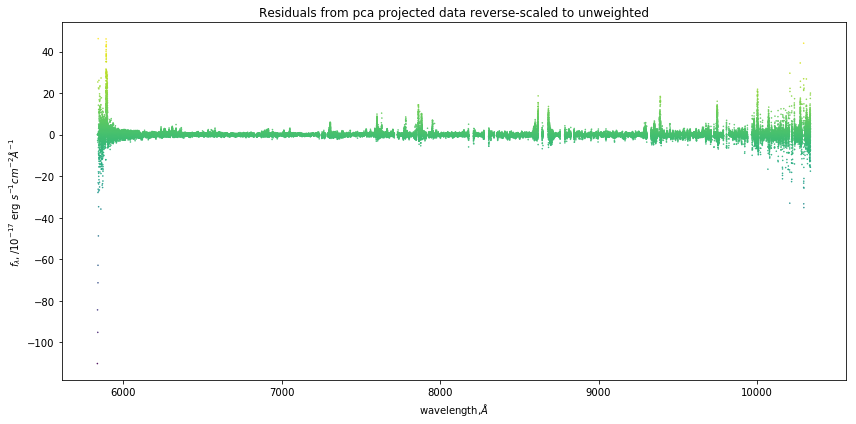

In [247]:
x = wavelength_spec1.data
y = projection_O_residual.data

plt.figure(figsize = (12,6))
plt.title("Residuals from pca projected data reverse-scaled to unweighted")
plt.xlabel("wavelength,$\AA$")
plt.ylabel("$f_{\lambda}, / 10^{-17}$ erg $s^{-1} cm^{-2} \AA^{-1}$")

plt.scatter(x,y,s=0.3, c=y)
plt.tight_layout()
plt.show()

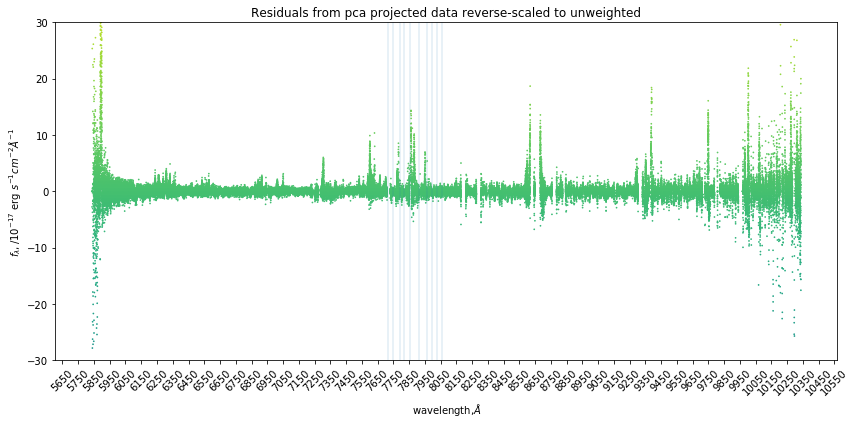

In [248]:
x = wavelength_spec1.data
y = projection_O_residual.data

plt.figure(figsize = (12,6))
plt.title("Residuals from pca projected data reverse-scaled to unweighted")
plt.xlabel("wavelength,$\AA$")
plt.ylabel("$f_{\lambda}, / 10^{-17}$ erg $s^{-1} cm^{-2} \AA^{-1}$")

plt.ylim(-30,30)

plt.xticks(np.arange(5150, 11001, step=100), rotation=45)
plt.yticks()

plt.scatter(x,y,s=0.5,c=y)

xcoords = [7714,7750,7794,7821,7853,7913,7964,7993,8025,8062]
for xc in xcoords:
    plt.axvline(x =xc, linewidth=0.2)

plt.tight_layout()
plt.show()

In [249]:
absolute_projection_O_residual = np.abs(projection_O_residual.data)

In [250]:
type(absolute_projection_O_residual)

numpy.ndarray

In [251]:
absolute_projection_O_residual.shape

(47, 4128)

#### Relative total flux residual
A relative total flux residual on sky fiber is defined as the ratio of absolute total flux residual to the original sky flux.

In [252]:
projection_O_residual_ratio = np.ma.array (absolute_projection_O_residual/ total_flux_spec1.data,mask=list(map(and_,total_flux_spec1.mask, projection_O_residual.mask)))

In [253]:
projection_O_residual_ratio.count()

102756

In [254]:
projection_O_residual_ratio.std()

7.971239328403717

In [255]:
projection_O_residual_ratio.mean(axis=0).count()

3110

In [256]:
np.max(projection_O_residual_ratio.mean(axis=0))

52.59821111505682

In [257]:
np.median(projection_O_residual_ratio.mean(axis=0))

/project/6016730/mlhaa/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


0.04925198903103836

In [258]:
np.mean(projection_O_residual_ratio.mean(axis=0))

0.08676186251393792

In [259]:
np.min(projection_O_residual_ratio.mean(axis=0))

-84.54588160021552

In [260]:
np.max(projection_O_residual_ratio.std(axis=0))

449.8045160884522

In [261]:
np.median(projection_O_residual_ratio.std(axis=0))

/project/6016730/mlhaa/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


0.035113468848672266

In [262]:
np.mean(projection_O_residual_ratio.std(axis=0))

0.3839460513921183

In [263]:
np.min(projection_O_residual_ratio.std(axis=0))

0.0

In [264]:
projection_O_rr_min = np.ma.filled(projection_O_residual_ratio, fill_value=0)

In [265]:
lower = np.min(projection_O_rr_min)

In [266]:
upper = np.max(projection_O_rr_min)

In [267]:
residual_f0 = projection_O_rr_min[:,0]

In [268]:
type(projection_O_rr_min)

numpy.ndarray

In [269]:
projection_O_rr_min

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [270]:
(residual_f0).shape

(47,)

In [271]:
type(np.linspace(lower, upper, num=20))

numpy.ndarray

In [ ]:
mu = 100
sigma = 15
x = mu + sigma*np.random.randn(10000)

In [ ]:
1

In [273]:
x

array([ 88.41644938,  85.14455792, 129.18224603, ...,  99.44152069,
       115.32875106, 116.01932708])

In [ ]:
n, bins, patches = plt.hist(x, bins =20)
plt.show()

n, bins, patches = plt.hist(projection_O_rr_min, bins=20)
plt.show()

1+1

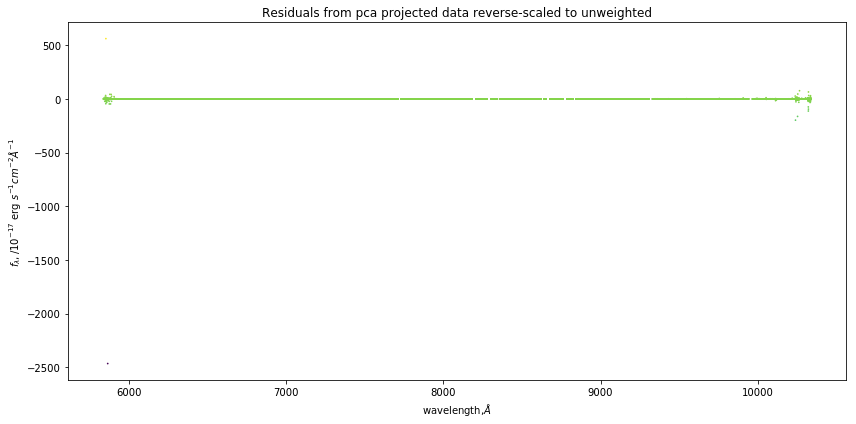

In [275]:
x = wavelength_spec1.data
y = projection_O_residual_ratio

plt.figure(figsize = (12,6))
plt.title("Residuals from pca projected data reverse-scaled to unweighted")
plt.xlabel("wavelength,$\AA$")
plt.ylabel("$f_{\lambda}, / 10^{-17}$ erg $s^{-1} cm^{-2} \AA^{-1}$")
plt.scatter(x,y,s=0.5,c=y)
plt.tight_layout()
plt.show()

In [276]:
pca_S_residual = scaled_total_sky - projection_S

In [277]:
type(pca_S_residual)

numpy.ma.core.MaskedArray

In [278]:
np.min(pca_S_residual.data)

-9.044071

In [279]:
np.max(pca_S_residual.data)

10.754646

In [280]:
np.std(pca_S_residual.data)

0.63993037

In [281]:
pca_S_residual.shape

(47, 4128)

In [282]:
scipy_stats.iqr(pca_S_residual.data)

0.09661418572068214

In [283]:
scipy_stats.iqr(pca_S_residual.data, axis=0)

array([0., 0., 0., ..., 0., 0., 0.])

In [284]:
np.median(scipy_stats.iqr(pca_S_residual.data, axis=0))

0.21738967578858137

Residual Scatter Plot on pca model with 47 components on noised-weighted Total Sky Flux.

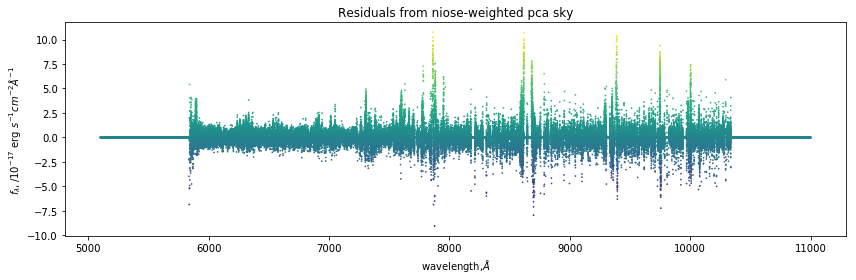

In [285]:
x = wavelength_spec1.data
y = pca_S_residual.data

plt.figure(figsize = (12,4))
plt.title("Residuals from niose-weighted pca sky")
plt.xlabel("wavelength,$\AA$")
plt.ylabel("$f_{\lambda}, / 10^{-17}$ erg $s^{-1} cm^{-2} \AA^{-1}$")
plt.scatter(x,y,s=0.5,c=y)
plt.tight_layout()
plt.show()

In [ ]:
plt.hist(pca_S_residual.data)
plt.title("Residuals from noise-weighted pca sky")
plt.xlabel("residuals in $f_{\lambda}, / 10^{-17}$ erg $s^{-1} cm^{-2} \AA^{-1}$")
plt.ylabel('Number of pixels')
plt.show()

Eigenvalues of original total flux input spectrum.

In [ ]:
eigenvalues_T = np.dot(total_flux_spec1.data, eigenvectors_S.T)

Standardized data has mean 0 and standard deviation 1. The sum of standard deviation across columns are lower than 3110, as there are some std below 1.

In [ ]:
X = total_flux_spec1.data

Standardize total flux matrix using Scipy z-score.

In [ ]:
X_scaled = scipy_stats.zscore(total_flux_spec1, axis=0)

In [ ]:
X_scaled.shape

Number of valid column

In [ ]:
X_scaled.std(axis=0).count()

Mean of zero.

In [ ]:
X_scaled.mean(axis=0).data.sum()

In [ ]:
np.mean(X_scaled.mean(axis=0).data)

In [ ]:
np.median(X_scaled.mean(axis=0).data)

In [ ]:
as_stats.median_absolute_deviation(X_scaled.mean(axis=0).data)

Standard deviation of one.

There are 3102 valid data points in total. The sum of all standard deviations should be close to 3102.

In [ ]:
X_scaled.std(axis=0).data.sum()

In [ ]:
np.mean(X_scaled.std(axis=0).data)

In [ ]:
np.median(X_scaled.std(axis=0).data)

In [ ]:
as_stats.median_absolute_deviation(X_scaled.std(axis=0).data)

Standardization through sklearn.preprocessing.StandardScaler.

It removes the mean and scale to unit variance.

In [ ]:
scaler = preprocessing.StandardScaler().fit(X)

In [ ]:
scaler.mean_

In [ ]:
scaler.scale_

In [ ]:
scaler.transform(X)

Mean of zero 0.

In [ ]:
scaler.transform(X).mean(axis=0).sum()

In [ ]:
np.mean(scaler.transform(X).mean(axis=0))

In [ ]:
np.median(scaler.transform(X).mean(axis=0))

In [ ]:
as_stats.median_absolute_deviation(scaler.transform(X).mean(axis=0))

Standard deviation of one. 
There are 3102 valid data points in total. The sum of all standard deviations should be close to 3102.

In [ ]:
scaler.transform(X).std(axis=0).sum()

In [ ]:
np.mean(scaler.transform(X).std(axis=0))

In [ ]:
np.median(scaler.transform(X).std(axis=0))

In [ ]:
as_stats.median_absolute_deviation(scaler.transform(X).std(axis=0))

In [ ]:
np.median(scaler.transform(X).std(axis=0)) + as_stats.median_absolute_deviation(scaler.transform(X).std(axis=0))

Standardization through sklearn.preprocessing.RobustScaler.

It removes the median and scales the data according to the quantile range.

In [ ]:
robust_scaler = preprocessing.RobustScaler().fit(X)

In [ ]:
robust_scaler.center_

In [ ]:
robust_scaler.scale_

In [ ]:
robust_scaler.transform(X)

In [ ]:
robust_scaler.transform(X).mean(axis=0).sum()

In [ ]:
np.mean(robust_scaler.transform(X).mean(axis=0))

In [ ]:
np.median(robust_scaler.transform(X).mean(axis=0))

In [ ]:
as_stats.median_absolute_deviation(robust_scaler.transform(X).mean(axis=0))

Standard deviation of one. 
There are 3102 valid data points in total. The sum of all standard deviations should be close to 3102.

In [ ]:
robust_scaler.transform(X).std(axis=0).sum()

In [ ]:
np.mean(robust_scaler.transform(X).std(axis=0))

In [ ]:
np.median(robust_scaler.transform(X).std(axis=0))

In [ ]:
as_stats.median_absolute_deviation(robust_scaler.transform(X).std(axis=0))

Manual standardization (Subtracting mean and divided by standard deviation).

In [ ]:
tf_sd = ma.std(total_flux_spec1, axis=0)

In [ ]:
tf_mean = ma.mean(total_flux_spec1,axis=0)

In [ ]:
total_flux_spec1.shape

In [ ]:
total_standardized = (total_flux_spec1-tf_mean)/tf_sd

In [ ]:
total_standardized.shape

In [ ]:
type(total_standardized)

Mean of zero.

In [ ]:
total_standardized.mean(axis=0).data.sum()

In [ ]:
np.mean(total_standardized.mean(axis=0).data)

In [ ]:
np.median(total_standardized.mean(axis=0).data)

In [ ]:
as_stats.median_absolute_deviation(total_standardized.mean(axis=0).data)

Standard deviation of one. 
There are 3102 valid data points in total. The sum of all standard deviations should be close to 3102.

In [ ]:
total_standardized.std(axis=0).data.sum()

In [ ]:
np.mean(total_standardized.std(axis=0).data)

In [ ]:
np.median(total_standardized.std(axis=0).data)

In [ ]:
as_stats.median_absolute_deviation(total_standardized.std(axis=0).data)

One MAD (median absolute deviation) interval from median mean and median standard deviation. The goal is to have a mean of 0 and a standard deviation of 1.

Interval for scipy.zscore and manual calculation.

In [ ]:
np.median(total_standardized.mean(axis=0).data) - as_stats.median_absolute_deviation(total_standardized.mean(axis=0).data)

In [ ]:
np.median(total_standardized.mean(axis=0).data) + as_stats.median_absolute_deviation(total_standardized.mean(axis=0).data)

In [ ]:
np.median(total_standardized.std(axis=0).data) - as_stats.median_absolute_deviation(total_standardized.std(axis=0).data)

In [ ]:
np.median(total_standardized.std(axis=0).data) + as_stats.median_absolute_deviation(total_standardized.std(axis=0).data)

Interval for preprocessing.Scaler calculation.

In [ ]:
np.median(scaler.transform(X).mean(axis=0)) - as_stats.median_absolute_deviation(scaler.transform(X).mean(axis=0))

In [ ]:
np.median(scaler.transform(X).mean(axis=0)) + as_stats.median_absolute_deviation(scaler.transform(X).mean(axis=0))

In [ ]:
np.median(scaler.transform(X).std(axis=0)) - as_stats.median_absolute_deviation(scaler.transform(X).std(axis=0))

In [ ]:
np.median(scaler.transform(X).std(axis=0)) + as_stats.median_absolute_deviation(scaler.transform(X).std(axis=0))

The standardization results obtained form using scipy.zscore and manual calculation are the same, while sklearn.preprocessing.StandardScaler provides the best standardization since its median deviation interval of the mean has range closer around 0, and its median deviation interval of the standard deviation contains 1.

#### Fit the model and apply dimensionality reduction on total flux of 47 sky fibers

In [ ]:
from sklearn import decomposition

In [ ]:
total_flux_scaled = scaler.transform(X)

In [ ]:
total_flux_scaled.shape

In [ ]:
pca = decomposition.PCA(n_components = 47)

In [ ]:
pca.fit(total_flux_scaled)

In [ ]:
print(pca.explained_variance_ratio_)

In [ ]:
np.sum([2.19207615e-01,1.54347777e-01, 1.03967294e-01 ,8.49681720e-02,
 5.80805168e-02 ,4.93013896e-02 ,4.04317826e-02 ,2.88645010e-02,
 2.25780495e-02 ,2.06022933e-02 ,1.73020922e-02, 1.25277927e-02,
 1.21007571e-02, 1.01174349e-02])

In [ ]:
total_flux_reduced = pca.fit_transform(total_flux_scaled)

Obtain eigenvectors (direction of principal components) from attribute of PCA Class.

In [ ]:
eigenvectors = pca.components_

In [ ]:
eigenvectors.shape

Calculate the eigenvalues (principal component amplitudes) for 47 sky spectra.
$$
a_j = f \cdot e_j
$$

$a_j$ are the principal component amplitudes(eigenvalues), $e_j$ are the eigenvectors.

In [ ]:
eigenvalues = np.dot(total_flux_spec1.data, eigenvectors.T)

In [ ]:
eigenvalues.shape

Plot the first five eigenvectors from pca.

A sample wavelength array from the first sky spectra is taken.

In [ ]:
arange(4)

In [ ]:
x = wavelength_spec1[0,:].data
y1 = eigenvectors[0]
y2 = eigenvectors[1]
y3 = eigenvectors[2]
y4 = eigenvectors[3]
y5 = eigenvectors[4]

plt.figure(figsize = (15,8))
plt.plot(x,y1,x,y2+0.1,x,y3+0.2,x,y4+0.3,x,y5+0.4)
start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(-0.1, 0.5, 60))
plt.show()

In [ ]:
# Eigenspectrum from the first principal component
x = wavelength_spec1[0,:].data
y = eigenvectors[0]

plt.figure(figsize = (15,5))
plt.plot(x,y)
plt.show()

In [ ]:
# Eigenspectrum from the second principal component
x = wavelength_spec1[0,:].data
y = eigenvectors[1]

plt.figure(figsize = (15,5))
plt.plot(x,y)
plt.show()

In [ ]:
# Eigenspectrum from the third principal component
x = wavelength_spec1[0,:].data
y = eigenvectors[2]

plt.figure(figsize = (15,5))
plt.plot(x,y)
plt.show()

In [ ]:
# Eigenspectrum from the fourth principal component
x = wavelength_spec1[0,:].data
y = eigenvectors[3]

plt.figure(figsize = (15,5))
plt.plot(x,y)
plt.show()

In [ ]:
# Eigenspectrum from the fifth principal component
x = wavelength_spec1[0,:].data
y = eigenvectors[4]

plt.figure(figsize = (15,5))
plt.plot(x,y)
plt.show()

In [ ]:
eigenvectors[0:5,:].shape

Reconstruct the input spectrum from eigenvectors and eigenvalues.
$$
f_k = \sum_{j=1}^{M} a_j e_{jk}
$$

In [ ]:
eigenvectors.shape

In [ ]:
projection = eigenvalues @ eigenvectors

In [ ]:
pca_residual = total_flux_spec1 - projection

Residual Scatter plot of pca model with 47 componets on Total Sky Flux.

In [ ]:
x = wavelength_spec1.data
y = pca_residual.data

plt.figure(figsize = (12,4))

plt.scatter(x,y,s=1,c =[0.2,0.5,0.])
plt.tight_layout()
plt.show()

A plot of wavelength vs. residuals from total flux of 47 sky fibers.

In [ ]:
x = wavelength_spec1.data
y = total_flux_residuals_sky_fiber.data

plt.figure(figsize = (12,4))
plt.scatter(x,y,s=1,c =[0.4,0.1,0.7])
plt.tight_layout()
plt.show()

In [ ]:
pca_residual_ratio = pca_residual / total_flux_spec1

In [ ]:
plt.hist(pca_residual_ratio, bins='auto')
plt.title("Total Flux from 47 sky fibers")
plt.xlabel('Ratio of pca residual')
plt.ylabel('Number of pixels')
plt.show()

Residual of total flux between first sky fiber and pca estimated first sky fiber. 

Obtain the mean and standard deviation of the principal components amplitudes, and the 5$\sigma$ intervals.

In [ ]:
eigen_mean = np.mean(eigenvalues,axis=0)

In [ ]:
eigen_sd = np.std(eigenvalues, axis=0)

In [ ]:
eigen_min = eigen_mean - 5*eigen_sd

In [ ]:
#eigen_min

In [ ]:
eigen_max = eigen_mean + 5*eigen_sd

In [ ]:
#eigen_max

# ?

Functions that remove spectra with principal component amplitudes more than 5$\sigma$ away from the mean.

In [ ]:
def remove_min (all_spectra, minimum):
    
    for i in range(all_spectra.shape[0]):
        for element in all_spectra[:,i]:
            if element < minimum[i]:
                all_spectra = np.delete(all_spectra,(i),axis=0)
                

In [ ]:
def remove(all_spectra,maximum,minimum):
    
    for i in range(all_spectra.shape[0]):
        for element in all_spectra[:,i]:
            if (element > maximum[i]) or (element < minimum[i]):
                all_spectra = np.delete(all_spectra,(i),axis=0)
                print(i)
                
                
    for i in range(all_spectra.shape[0]):
        for element in all_spectra[:,i]:
            if element < minimum[i]:
                all_spectra = np.delete(all_spectra,(i),axis=0)
                print(i)
                
    return all_spectra

A function to find outlying eigenvalue indices for those more than 5$\sigma$ away from the mean.

In [ ]:
def find_outlier(all_spectra):
    '''Find lists of indices of outlying eigenvalue spectra. 
    
    Parameters
    ----------
    all_spectra: An numpy ndarray containing eigenvalues from the pca
    
    Returns
    --------
    One list for lower outliers below the minimum value, and another list for upper outliers above the maximum value.
    '''
    upper_outlier = []
    lower_outlier = []
    for i in range(all_spectra.shape[0]):
        for element in all_spectra[:,i]:
            if element < eigen_min[i]:
                lower_outlier.append(i)
            if element > eigen_max[i]:
                upper_outlier.append(i)
    return lower_outlier, upper_outlier

In [ ]:
find_outlier(eigenvalues)

In [ ]:
outlier_index = sorted(find_outlier(eigenvalues)[0]+find_outlier(eigenvalues)[1])

In [ ]:
outlier_index

In [ ]:
len(outlier_index)

Removing those outlying sky spectra, which leaves 37 spectra within the 5$\sigma$ range.

In [ ]:
total_flux_removed = np.delete(total_flux_spec1,outlier_index,axis=0)

In [ ]:
total_flux_removed.shape

In [ ]:
type(total_flux_removed)

#### Fit the model and apply dimensionality reduction on total flux of 37 sky fibers

Perform PCA after removal of those outlying spectra.

In [ ]:
Y = total_flux_removed.data

Standardize outlier-removed spectra using StandardScaler

In [ ]:
scaler_removed = preprocessing.StandardScaler().fit(Y)

In [ ]:
scaler_removed.mean_

In [ ]:
scaler_removed.scale_

In [ ]:
scaler_removed.transform(Y)

In [ ]:
total_flux_removed_scaled = scaler_removed.transform(Y)

In [ ]:
type(total_flux_removed_scaled)

In [ ]:
pca_removed = decomposition.PCA(n_components = 37)

In [ ]:
pca_removed.fit(total_flux_removed_scaled)

In [ ]:
print(pca_removed.explained_variance_ratio_)

In [ ]:
type(pca_removed.explained_variance_ratio_)

In [ ]:
def get_variance_sum(variance, number):
    '''Return the total proportion of explained variance with corresponding input number of components in percentage terms.
    
    Parameters
    ----------
    variance: numpy array containing explained variance ratio from the pca output
    number: specified number of componenets to keep
    
    Returns:
    A sum of explained variance proportion and the number of componenets
    '''
    variance_sum = 0
    for n in range(number):
        variance_sum = variance_sum + variance[n]
    print (number, "components explain" ,variance_sum*100 ,"% of variantion")

In [ ]:
get_variance_sum(pca_removed.explained_variance_ratio_, 15)

In [ ]:
def above_one_percent_variance_ratio(variance):
    '''Return the sum of those explained variance ratio above 1 percent with the total number of such variances.
    
    Parameters
    ----------
    variance: numpy array containing explained variance ratio from the pca output
    
    Returns
    -------
    The number of explained variances with ratio above 1 percent and a sum of their ratios.
    '''
    componenets_to_keep = []
    number_of_components = 0
    for i in variance:
        if i > 0.01:
            componenets_to_keep.append(i)
            number_of_components = number_of_components +1
    return np.sum(componenets_to_keep), number_of_components

In [ ]:
above_one_percent_variance_ratio(pca.explained_variance_ratio_)

There are 14 components with explained variance ratio above 1 percent in the pca fitting of the original 47 sky fibers.

In [ ]:
above_one_percent_variance_ratio(pca_removed.explained_variance_ratio_)

There are 15 components with explained variance ratio above 1 percent in the pca fitting of the outlier-removed 37 sky fibers.

Obtain eigenvectors(direction of principal components) for 37 outlier-removed sky fibers.

In [ ]:
eigenvectors_sample = pca_removed.components_

In [ ]:
eigenvectors_sample.shape

Calculate the eigenvalues (principal component amplitudes) for 37 sky spectra.
$$
a_j = f \cdot e_j
$$

$a_j$ are the principal component amplitudes(eigenvalues), $e_j$ are the eigenvectors.

In [ ]:
eigenvalues_sample = np.dot(total_flux_spec1.data, eigenvectors_sample.T)

In [ ]:
eigenvalues_sample.shape

Plot the first five eigenvectors.

A sample wavelength array from the first sky spectra is taken.

In [ ]:
x = wavelength_spec1[0,:].data
y1 = eigenvectors_sample[0]
y2 = eigenvectors_sample[1]
y3 = eigenvectors_sample[2]
y4 = eigenvectors_sample[3]
y5 = eigenvectors_sample[4]

plt.figure(figsize = (15,8))
plt.plot(x,y1,x,y2+0.1,x,y3+0.2,x,y4+0.3,x,y5+0.4)
start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(-0.1, 0.5, 60))
plt.show()

Reconstruct the input spectrum from eigenvectors and eigenvalues.
$$
f_k = \sum_{j=1}^{M} a_j e_{jk}
$$

In [ ]:
eigenvectors_sample.shape

In [ ]:
projection_sample = eigenvalues_sample @ eigenvectors_sample

In [ ]:
projection_sample.shape

In [ ]:
pca_residual_sample = total_flux_spec1 - projection_sample

Residual Scatter plot of pca model with 37 components on Total Sky Flux.

In [ ]:
x = wavelength_spec1.data
y = pca_residual_sample.data

plt.figure(figsize = (12,4))

plt.scatter(x,y,s=1,c =[0.2,0.5,0.6])
plt.tight_layout()
plt.show()

In [ ]:
pca_residual_sample_ratio = pca_residual_sample / total_flux_spec1

In [ ]:
plt.hist(pca_residual_sample_ratio, bins='auto')
plt.title("Total Flux from 47 sky fibers")
plt.xlabel('Ratio of outlier-removed pca residual')
plt.ylabel('Number of pixels')
plt.show()

Residual of total flux between first sky fiber and pca estimated first sky fiber. 

In [ ]:
principalComponents = pca.fit_transform()

In [ ]:
print(pca.explained_variance_ratio_)

In [ ]:
print(pca.singular_values_)

In [ ]:
pca.explained_variance_ratio_.sum()

In [ ]:
# Explained variance of first 5 principal components
0.21920775 + 0.15434761 + 0.10396753 + 0.08496818 + 0.05808052

In [ ]:
pca = PCA(n_components=100)

In [ ]:
pca.fit(X)

In [ ]:
print(pca.explained_variance_ratio_)

### PCA on residuals from average subtracted total flux on sky fibers

In [ ]:
pca = PCA(n_components=8)

In [ ]:
Y = StandardScaler().fit_transform(total_flux_residuals_sky_fiber.data)

In [ ]:
pca.fit(Y)

In [ ]:
print(pca.explained_variance_ratio_)

In [ ]:
pca = PCA(n_components=4)

In [ ]:
Y = StandardScaler().fit_transform(total_flux_residuals_sky_fiber.data)

In [ ]:
pca.fit(Y)

In [ ]:
print(pca.explained_variance_ratio_)

### Testing of weighted average

In [ ]:
total_flux_spec1.shape

In [ ]:
average_sky_flux1.shape

In [ ]:
type(weighted_average_spec1)

In [355]:
weighted_average_spec1.shape

(4128,)

In [353]:
weighted_average_spec1.count()

3110

In [347]:
type(average_sky_flux1)

numpy.ndarray

In [348]:
len(average_sky_flux1)

4128

#### Total Flux of SKY Fibers subtracted by the average sky signal
Subtract Average Total Flux of Sky Fibers from Total Flux of each SKY Fibers

Replicate average_sky_flux1 to dimension of (47, 4128).

In [211]:
repeated47_average_sky_flux1 = np.tile(average_sky_flux1, (47,1))

In [212]:
repeated47_average_sky_flux1.shape

(47, 4128)

In [458]:
np.max(repeated47_average_sky_flux1)

104.62009

In [459]:
np.median(repeated47_average_sky_flux1)

5.293231

In [460]:
np.min(repeated47_average_sky_flux1)

0.0

Inspection of total_flux_spec1

In [453]:
np.min(total_flux_spec1.data)

-51.820637

In [444]:
np.median(total_flux_spec1.data)

5.7267346

In [427]:
np.max(total_flux_spec1.data)

2692.287

A plot of wavelength vs. median residuals across fibers from total flux of 47 sky fibers.

In [484]:
residual_median_across_fibers = np.median(total_flux_residuals_sky_fiber.data, axis=0)

In [485]:
residual_median_across_fibers.shape

(4128,)

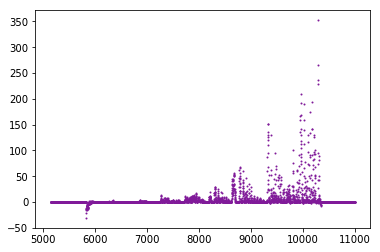

In [486]:
x = wavelength_spec1.data[0]
y = residual_median_across_fibers

plt.scatter(x,y,s=1, c=[0.5,0.1,0.6])
plt.show()

Median Absolute Deviation

In [494]:
residuals_mad = stats.median_absolute_deviation(total_flux_residuals_sky_fiber.data)

In [501]:
total_flux_residuals_sky_fiber.data.shape

(47, 4128)

In [505]:
residuals_mad

0.91774154

In [502]:
flattened_residuals = np.ndarray.flatten(total_flux_residuals_sky_fiber.data)

In [508]:
statistics = abs(total_flux_residuals_sky_fiber-residuals_mad)/residuals_mad

In [511]:
statistics.shape

(47, 4128)

In [ ]:
for i in statistics

In [512]:
np.mean(statistics.data)

9.828066

In [513]:
np.min(statistics.data)

0.0

In [515]:
np.median(statistics.data)

1.386084

In [514]:
np.max(statistics.data)

2655.9468

In [ ]:
total_flux

In [503]:
flattened_residuals.shape

(194016,)

In [1288]:
for i in flattened_residuals:
    lower_mad = []
    higher_mad = []
    if i < residuals_mad:
        lower_mad.append([i])
        higher_mad.append([i])

NameError: name 'flattened_residuals' is not defined

In [ ]:
def doubleMAD

In [496]:
residuals_mad_across_fibers = stats.median_absolute_deviation(total_flux_residuals_sky_fiber.data, axis=0)

(4128,)

Comparison between estimated average sky signal and total flux from 47 Sky fibers.

0.6744907594765952

#### Sky Flux of SKY Fibers subtracted by the average sky signal
Subtract Average Total Flux of Sky Fibers from Sky Flux of each SKY Fibers

In [195]:
sky_residuals_sky_fiber = np.ma.array(sky_spec1.data - repeated47_average_sky_flux1, mask = sky_spec1.mask)

NameError: name 'repeated47_average_sky_flux1' is not defined

In [408]:
sky_residuals_sky_fiber.shape

(47, 4128)

In [445]:
sky_residual_median_along_fiber = np.median(sky_residuals_sky_fiber.data)

In [446]:
np.min(sky_residual_median_along_fiber)

0.0

In [447]:
np.max(sky_residual_median_along_fiber)

0.0

In [438]:
stats.median_absolute_deviation(sky_residuals_sky_fiber.data, axis =1)

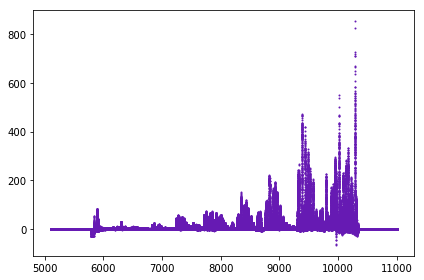

In [439]:
x = wavelength_spec1.data
y = sky_residuals_sky_fiber.data

plt.scatter(x,y,s=1,c =[0.4,0.1,0.7])
plt.tight_layout()
plt.show()

### Non-SKY Fibers

The weighted average of total_flux from sky fibers are subtracted from the total_flux from non-sky fibers. The difference is compared to the flux values from non-sky fibers to check the weighted average's accuracy.

#### Get valid data for the 453 non-sky fibers in Spectrograph 1.

In [194]:
spec1_non_sky = expo0_spec1_frame.get_valid_data(fibers = non_sky_fibers1, pixel_quality_mask=None, include_wdisp=False, include_sky=True, use_ivar=True, use_loglam=False)

In [249]:
spec1_non_sky.shape

(453, 4128)

In [250]:
type(spec1_non_sky)

numpy.ma.core.MaskedArray

#### Non-SKY Flux

In [251]:
flux_non_sky_spec1 = spec1_non_sky['flux']

In [252]:
flux_non_sky_spec1.shape

(453, 4128)

In [254]:
#flux_non_sky_spec1.count(axis=1)

In [255]:
flux_non_sky_spec1.count(axis=1).sum()

1000417

In [256]:
453 * 4128

1869984

#### Non-SKY Sky

In [257]:
sky_non_sky_spec1 = spec1_non_sky['sky']

In [258]:
sky_non_sky_spec1.shape

(453, 4128)

In [368]:
len(sky_non_sky_spec1.count(axis=1))

453

#### Non-SKY Sky + Flux

In [260]:
total_flux_non_sky_spec1 = np.ma.array(flux_non_sky_spec1.data + sky_non_sky_spec1.data, mask = list(map(and_, flux_non_sky_spec1.mask, sky_non_sky_spec1.mask)))

In [261]:
total_flux_non_sky_spec1.shape

(453, 4128)

In [263]:
total_flux_non_sky_spec1.count(axis=1).sum()

1000417

#### Weighted average sky subtracted from Non-SKY Total Flux

In [387]:
weighted_average_spec1

masked_array(data=[--, --, --, ..., --, --, --],
             mask=[ True,  True,  True, ...,  True,  True,  True],
       fill_value=1e+20,
            dtype=float32)

In [276]:
weighted_average_spec1.shape

(4128,)

In [277]:
type(weighted_average_spec1.data)

numpy.ndarray

In [278]:
weighted_average_spec1.shape

(4128,)

In [292]:
type(average_sky_flux1)

numpy.ndarray

In [289]:
average_sky_flux1.shape

(4128,)

In [357]:
repeated453_average_sky_flux1 = np.tile(average_sky_flux1, (453,1))

In [386]:
repeated453_average_sky_flux1.shape

(453, 4128)

#### Object Flux by subtraction for all non-SKY Fibers
Subtract Average Total Flux of Sky Fibers from Total Flux of non-SKY Fibers

In [314]:
calculated_flux_spec1 =np.ma.array(total_flux_non_sky_spec1.data - repeated_average_sky_flux1, mask = total_flux_non_sky_spec1.mask)

In [315]:
type(calculated_flux_spec1)

numpy.ma.core.MaskedArray

In [316]:
calculated_flux_spec1.shape

(453, 4128)

Comparison between calculated flux and original flux from Non-SKY Fiber data

In [317]:
difference_flux_spec1 = calculated_flux_spec1.data - flux_non_sky_spec1.data

In [388]:
#abs(difference_flux_spec1)/ flux_non_sky_spec1.data

In [319]:
type(difference_flux_spec1)

numpy.ndarray

In [328]:
difference_flux_spec1.mean(axis=0).mean()

3.9319134

In [329]:
flux_non_sky_spec1.data.max()

5059.031

In [330]:
flux_non_sky_spec1.data.min()

-132.85898

### Exposure[0], Spectrograph 2, Fiber 501-1000

Locate and download the file of a single science exposure for spectrogtaph 2. The exposure file to return is set to 'spCFrame'.

In [118]:
exp0_spec2_path = combined_plan.get_exposure_name(sequence_number=0,band='red',fiber = 501,ftype='spCFrame')

In [119]:
exp0_spec2_path

'/sas/dr12/boss/spectro/redux/v5_7_0/4042/spCFrame-r2-00127588.fits'

In [120]:
exp0_spec2_file = mirror.get(exp0_spec2_path)

In [121]:
exp0_spec2_file

'/scratch/kunjias/sdss/sas/dr12/boss/spectro/redux/v5_7_0/4042/spCFrame-r2-00127588.fits'

#### Frame file of exposure[0] of spectrograph 2

Frame file containing single exposure 0 of spectrograph 2 (half plate).

In [122]:
expo0_spec2_frame = plate.FrameFile(exp0_spec2_file, index=2, calibrated = True)

In [123]:
# expo0_spec2_frame
print("plate_number:",expo0_spec2_frame.plate,
'camera:',expo0_spec2_frame.camera,
'exposure_id:',expo0_spec2_frame.exposure_id)
# expo0_spec2_frame.header

plate_number: 4042 camera: r2 exposure_id: 127588


#### Get valid data for the 50 sky fibers in Spectrograph 2.

In [126]:
spec2_sky = expo0_spec2_frame.get_valid_data(fibers = sky_fibers2, pixel_quality_mask=None, include_wdisp=False, include_sky=True, use_ivar=True, use_loglam=False)

In [127]:
# spec2_sky

In [128]:
spec2_sky.shape

(50, 4128)

In [129]:
type(spec2_sky)

numpy.ma.core.MaskedArray

Access the wavelength, flux, sky, and ivar fields by creating new masked arrays.

#### Wavelength

In [135]:
wavelength_spec2 = spec2_sky['wavelength']

In [136]:
wavelength_spec2.shape

(50, 4128)

Total number of data points if all are valid.

In [138]:
50 * 4128

206400

Count the number of non-masked elements along rows (fibers).

In [139]:
wavelength_spec2.count(axis=1)

array([4128, 4128, 4128, 4128, 4128, 4128, 4128, 4128, 4128, 4128, 4128,
       4128, 4128, 4128, 4128, 4128, 4128, 4128, 4128, 4128, 4128, 4128,
       4128, 4128, 4128, 4128, 4128, 4128, 4128, 4128, 4128, 4128, 4128,
       4128, 4128, 4128, 4128, 4128, 4128, 4128, 4128, 4128, 4128, 4128,
       4128, 4128, 4128, 4128, 4128, 4128])

Total number of valid elements in the flux  masked array.

In [140]:
wavelength_spec2.count(axis=1).sum()

206400

#### FLux

In [141]:
flux_spec2 = spec2_sky['flux']

In [142]:
flux_spec2.shape

(50, 4128)

In [143]:
flux_spec2.count(axis=1)

array([2300, 2254, 2296, 2288, 2314, 2294, 2279, 2268, 2291, 2311, 2269,
       2276, 2302, 2232, 2306, 2278, 2242, 2241, 2233, 2268, 2261, 2237,
       2245, 2250, 2240, 2219, 2244, 2278, 2268, 2261, 2272, 2278, 2223,
       2221, 2278, 2271, 2274, 2261, 2230, 2247, 2280, 2296, 2267, 2265,
       2254, 2244, 2221, 2297, 2229, 2248])

In [144]:
flux_spec2.count(axis=1).sum()

113201

#### Sky

In [145]:
sky_spec2 = spec2_sky['sky']

In [146]:
sky_spec2.count(axis=1)

array([2300, 2254, 2296, 2288, 2314, 2294, 2279, 2268, 2291, 2311, 2269,
       2276, 2302, 2232, 2306, 2278, 2242, 2241, 2233, 2268, 2261, 2237,
       2245, 2250, 2240, 2219, 2244, 2278, 2268, 2261, 2272, 2278, 2223,
       2221, 2278, 2271, 2274, 2261, 2230, 2247, 2280, 2296, 2267, 2265,
       2254, 2244, 2221, 2297, 2229, 2248])

In [147]:
sky_spec2.count(axis=1).sum()

113201

#### Sky + Flux

In [172]:
total_flux_spec2 = np.ma.array(flux_spec2.data + sky_spec2.data, mask=list(map(and_,flux_spec2.mask, sky_spec2.mask)))

In [149]:
total_flux_spec2.shape

(50, 4128)

In [150]:
total_flux_spec2.count(axis=1)

array([2300, 2254, 2296, 2288, 2314, 2294, 2279, 2268, 2291, 2311, 2269,
       2276, 2302, 2232, 2306, 2278, 2242, 2241, 2233, 2268, 2261, 2237,
       2245, 2250, 2240, 2219, 2244, 2278, 2268, 2261, 2272, 2278, 2223,
       2221, 2278, 2271, 2274, 2261, 2230, 2247, 2280, 2296, 2267, 2265,
       2254, 2244, 2221, 2297, 2229, 2248])

Check the total number of valid data in total_flux.

In [151]:
len(total_flux_spec2.compressed())

113201

#### Inverse Variance

Inverse Variance is used as weights to computed the weighted average of total flux for sky fibers.

In [152]:
ivar_spec2 = spec2_sky['ivar']

In [153]:
type(ivar_spec2)

numpy.ma.core.MaskedArray

In [154]:
ivar_spec2.shape

(50, 4128)

Check number of valid data in the inverse variance masked array.

In [155]:
ivar_spec2.count(axis=1).sum()

113201

Fill in the invalid inverse variance data with value 0.

In [156]:
weights_by_ivar2 = ma.filled(ivar_spec2, fill_value=0)

In [157]:
type(weights_by_ivar2)

numpy.ndarray

In [158]:
weights_by_ivar2.shape

(50, 4128)

A plot for the total flux among the 50 sky fibers in spectrograph 2.

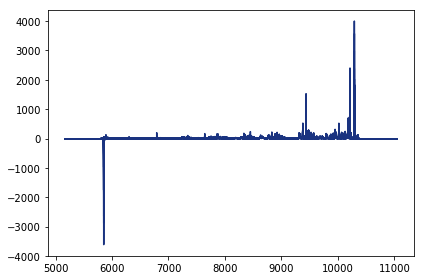

In [171]:
x = wavelength_spec2.data
y = total_flux_spec2.data
plt.plot(x,y,c=[0.1,0.2,0.5])
plt.tight_layout()
plt.show()

#### Simple Average
Average of total_flux among 50 sky fibers without no weights.

In [159]:
simple_average2 = ma.average(total_flux_spec2, axis=0, returned=False)

In [160]:
type(simple_average2)

numpy.ma.core.MaskedArray

In [161]:
simple_average_flux2 = simple_average2.data

Wavelegnth from the first sky fiber (fiber no.14) is taken as the standard wavelength scale to plot the total_flux here.

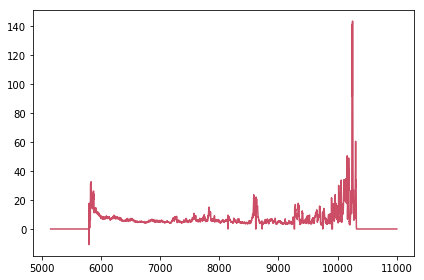

In [162]:
x = wavelength_fiber14
y = simple_average_flux2
plt.plot(x,y,c =[0.8,0.3,0.4])
plt.tight_layout()
plt.show()

#### Weighted Average
Average of total_flux of 50 sky fibers in spectrograph 2 weighted by inverse variance.

In [271]:
weighted_average_spec2 = ma.average(total_flux_spec2,axis=0, weights = weights_by_ivar2, returned= False)

In [272]:
type(weighted_average_spec2)

numpy.ma.core.MaskedArray

In [273]:
average_sky_flux2 = weighted_average_spec2.data

Wavelegnth from the first sky fiber (fiber no.14) is taken as the standard wavelength scale to plot the total_flux here.

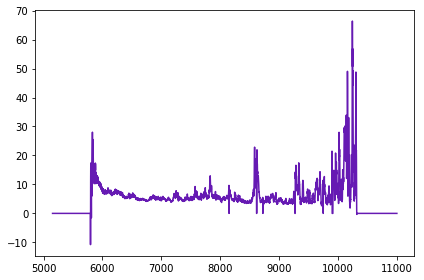

In [274]:
x = wavelength_fiber14
y = average_sky_flux2
plt.plot(x,y,c =[0.4,0.1,0.7])
plt.tight_layout()
plt.show()